In [1]:
import tensorflow as tf

import random
from glob import glob
from typing import List,Tuple
from pathlib import Path
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['CUDA_VISIBLE_DEVICES']="7,4"

2.3.0
Num GPUs Available:  8


In [2]:

# function to contruct back from tf record example
def prepare_sample(example):
    example["grid_map"] = tf.io.decode_raw(example["grid_map"], out_type=tf.int8)
    example["grid_map"] = tf.reshape(example["grid_map"],[1536,1536])

    example["grid_org_res"] = tf.io.decode_raw(example["grid_org_res"], out_type=tf.float32)
    #example["grid_org_res"] = tf.reshape(example["grid_org_res"],[1,3])

    example["left_bnd"] = tf.io.decode_raw(example["left_bnd"], out_type=tf.float32)
    example["left_bnd"] = tf.reshape(example["left_bnd"],[25,2])

    example["right_bnd"] = tf.io.decode_raw(example["right_bnd"], out_type=tf.float32)
    example["right_bnd"] = tf.reshape(example["right_bnd"],[25,2])

    example["car_odo"] = tf.io.decode_raw(example["car_odo"], out_type=tf.float32)
    #example["car_odo"] = tf.reshape(example["car_odo"],[1,3])

    example["init_path"] = tf.io.decode_raw(example["init_path"], out_type=tf.float32)
    example["init_path"] = tf.reshape(example["init_path"],[25,2])

    example["opt_path"] = tf.io.decode_raw(example["opt_path"], out_type=tf.float32)
    example["opt_path"] = tf.reshape(example["opt_path"],[25,2])

    return (example["grid_map"],example["grid_org_res"],example["left_bnd"],example["right_bnd"],example["car_odo"],example["init_path"]),example["opt_path"]


def parse_tfrecord_fn_ds(example):

    # Dict of feature and their description
    feature_description = {

        # model inputs
        "grid_map": tf.io.FixedLenFeature([], tf.string),
        "grid_org_res": tf.io.FixedLenFeature([], tf.string),
        "left_bnd": tf.io.FixedLenFeature([], tf.string),
        "right_bnd": tf.io.FixedLenFeature([], tf.string),
        "car_odo": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        
        #model ouput
        "opt_path": tf.io.FixedLenFeature([], tf.string),

    }

    # Parse a single Example proto
    example = tf.io.parse_single_example(example, feature_description)
    return example

In [3]:
def get_dataset(filenames, batch_size, data_set_name:str):
    try:
        assert data_set_name in ("train","valid","test")
        dataset = (
            tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_fn_ds, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample, num_parallel_calls=AUTOTUNE)
            )
        if data_set_name=='train':
            dataset = dataset.shuffle(batch_size * 10)

        dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

    except AssertionError as Err:
        print(f"Build failed,{Err}")

    return dataset

def shuffle_nd_split(list_paths:List[Path],train_size:float=0.7)->Tuple[List[Path],List[Path],List[Path]]:
    list_train,list_test= train_test_split(list_paths,test_size=1-train_size)
    list_test,list_valid= train_test_split(list_test,test_size=0.5)

    return list_train,list_valid,list_test


In [4]:
tfrecords_dir = '/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records'
#r'D:\tf_records'
tfrec_paths = glob(f"{tfrecords_dir}/**/*.tfrec",recursive=True)
#random.shuffle(tfrec_paths)

ds_train,ds_valid,ds_test = shuffle_nd_split(tfrec_paths,train_size=0.7)

In [5]:
print(len(ds_train),len(ds_valid),len(ds_test))

408 88 87


In [6]:
ds_train= get_dataset(ds_train,batch_size=32,data_set_name='train')
ds_test= get_dataset(ds_test,batch_size=32,data_set_name='test')
ds_valid= get_dataset(ds_valid,batch_size=32,data_set_name='valid')

In [7]:
ds_train.element_spec

((TensorSpec(shape=(None, 1536, 1536), dtype=tf.int8, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None))

In [8]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow tensor
    :param y_p red: TensorFlow tensor of the same shape as y_true
    :return: float
    """
    #original euclidean distance loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    loss = K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))
    return loss


#(example["grid_map"],example["grid_org_res"],example["left_bnd"],example["right_bnd"],example#["car_odo"],example["init_path"])

def nn():

    # Grid Map input
    ip_gridmap = layers.Input(shape=(1536,1536,1))

    #CNN - branch1
    #1x1 conv 
    #x_A = layers.Conv2D(3,kernel_size=1,strides=1)(ip_gridmap)
    
    x_A = layers.Conv2D(16,kernel_size=7,strides=2)(ip_gridmap)
    x_A = layers.ReLU()(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    x_A = layers.Conv2D(32,kernel_size=5,strides=2)(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    
    x_A = layers.Conv2D(64,kernel_size=3,strides=2)(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(2,2))(x_A)


    x_A = layers.Flatten()(x_A)


    # Other inputs
    ip_grid_org_res = layers.Input(shape=(3,))
    ip_left_bnd = layers.Input(shape=(25,2))
    ip_right_bnd = layers.Input(shape=(25,2))
    ip_car_odo = layers.Input(shape=(3,))
    ip_init_path = layers.Input(shape=(25,2))
    
    """
    #branch 2
    x_B = layers.Conv1D(2,kernel_size=3,padding='same')(ip_init_path)
    #branch 3
    x_C = layers.Conv1D(2,kernel_size=3,padding='same')(ip_left_bnd)
    #branch 4
    x_D = layers.Conv1D(2,kernel_size=3,padding='same')(ip_right_bnd)
    """
    
    # branch 5
    conc_grid_orgres_car_odo = layers.concatenate([ip_grid_org_res,ip_car_odo])


    reshape_init_path = layers.Reshape((50,))(ip_init_path)
    reshape_left_bnd = layers.Reshape((50,))(ip_left_bnd)
    reshape_right_bnd = layers.Reshape((50,))(ip_right_bnd)

    
    #concatenate feature
    concat_feat = layers.concatenate([x_A, reshape_init_path, reshape_left_bnd, reshape_right_bnd, conc_grid_orgres_car_odo])

    #output = layers.Lambda(lambda x: tf.expand_dims(x, -1))(concat_feat)

    #FC
    #output = layers.Convolution1D(50,kernel_size=3,padding='valid',activation='relu')(concat_feat)
    
    output = layers.Dense(128, activation='linear')(concat_feat)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    #output = layers.Dropout(0.6)(output)
    
    
    output = layers.Dense(96, activation='linear')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    #output = layers.Dropout(0.2)(output)
    
    
    output = layers.Dense(64, activation='linear')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    #output = layers.Dropout(0.2)(output)
    
    
    output = layers.Dense(50, activation='linear')(output)
    
    output = layers.Reshape((25,2))(output)
    
    nn_fun = keras.models.Model(inputs = [ip_gridmap,ip_grid_org_res,ip_left_bnd, ip_right_bnd, ip_car_odo, ip_init_path], outputs= output)
    
    return nn_fun

In [9]:
pp_model = nn()
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001)
pp_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1536, 1536,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 765, 765, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 765, 765, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 765, 765, 16) 64          re_lu[0][0]                      
_______________________________________________________________________________________

In [10]:
history = pp_model.fit(ds_train,epochs=50,validation_data=ds_valid, callbacks=[reduce_lr])

Epoch 1/50
194/194 [==============================] - 89s 457ms/step - loss: 100.6463 - accuracy: 0.9501 - val_loss: 225.9643 - val_accuracy: 0.9621
Epoch 2/50
194/194 [==============================] - 24s 123ms/step - loss: 58.0099 - accuracy: 0.9252 - val_loss: 192.7936 - val_accuracy: 0.9621
Epoch 3/50
194/194 [==============================] - 24s 122ms/step - loss: 46.5579 - accuracy: 0.9287 - val_loss: 91.7709 - val_accuracy: 0.9781
Epoch 4/50
194/194 [==============================] - 24s 121ms/step - loss: 44.0262 - accuracy: 0.9444 - val_loss: 65.8195 - val_accuracy: 0.7457
Epoch 5/50
194/194 [==============================] - 24s 122ms/step - loss: 40.4262 - accuracy: 0.9471 - val_loss: 47.7446 - val_accuracy: 0.9621
Epoch 6/50
194/194 [==============================] - 24s 121ms/step - loss: 42.0963 - accuracy: 0.9231 - val_loss: 26.7069 - val_accuracy: 0.9771
Epoch 7/50
194/194 [==============================] - 24s 121ms/step - loss: 36.9039 - accuracy: 0.9469 - val_loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


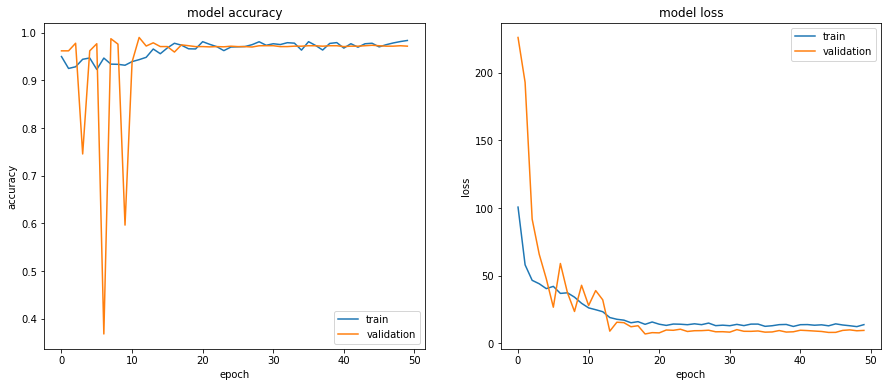

In [11]:

plt.figure(figsize=(15, 6))

print(history.history.keys())
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.show()

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.suptitle("Conv + LSTM + Dense Head")
plt.show()

In [12]:
pp_model.evaluate(ds_test)

41/41 [==============================] - 25s 610ms/step - loss: 8.3885 - accuracy: 0.9888


[8.38845443725586, 0.9888299703598022]

In [21]:
predictions = pp_model.predict(ds_test)